In [1]:
import glob
from utils import *
import pandas as pd
import matplotlib.pyplot as plt

pygame 2.6.1 (SDL 2.30.10, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


In [2]:
data_files = ['data/demos_no_braking.npz']
#data_files = ['data/demos_no_braking.npz', 'data/demos_with_braking.npz']
#data_files = ['data/demos_no_braking.npz', 'data/demos_with_braking.npz', 'data/demos_recovery.npz']
observations, actions = load_demonstrations(data_files)

In [3]:
# check expected values
df = pd.DataFrame(np.asarray(actions), columns=['steer', 'accel', 'brake'])
assert np.array_equal(np.sort(df['steer'].unique()), [-1.,  0.,  1.])
assert np.array_equal(np.sort(df['accel'].unique()), [0.,  0.5])
assert np.array_equal(np.sort(df['brake'].unique()), [0.,  0.8]) or np.array_equal(np.sort(df['brake'].unique()), [0.])

classes = [
    [-1.0, 0.0, 0.0],  # 0: Left
    [-1.0, 0.5, 0.0],  # 1: left with acceleration
    [-1.0, 0.0, 0.8],  # 2: left with brakes
    [1.0, 0.0, 0.0],   # 3: right
    [1.0, 0.5, 0.0],   # 4: right with acceleration
    [1.0, 0.0, 0.8],   # 5: right with brakes
    [0.0, 0.0, 0.0],   # 6: straight
    [0.0, 0.5, 0.0],   # 7: straight with acceleration
    [0.0, 0.0, 0.8]    # 8: straight with brakes
]  

def actions_to_class(actions):
    np_actions = np.asarray(actions)
    one_hot = np.zeros((np_actions.shape[0], len(classes)))
    for idx in range(len(classes)):
        one_hot[:, idx] = np.all(np_actions == classes[idx], axis=1)
        
    class_number = np.where(one_hot)[1]
    return class_number, one_hot

df = pd.DataFrame(np.asarray(actions), columns=['steer', 'accel', 'brake'])
class_number, one_hot = actions_to_class(actions)
df['class_number'] = class_number
df['class_number'].value_counts()

class_number
6    4283
0     312
7     233
3     106
1      80
4      26
Name: count, dtype: int64

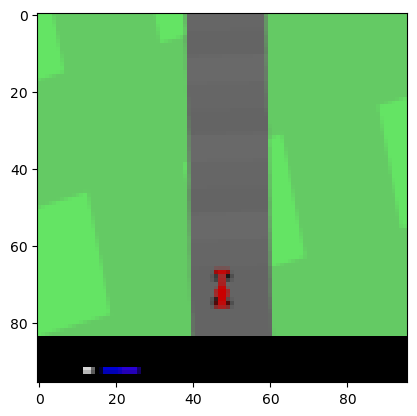

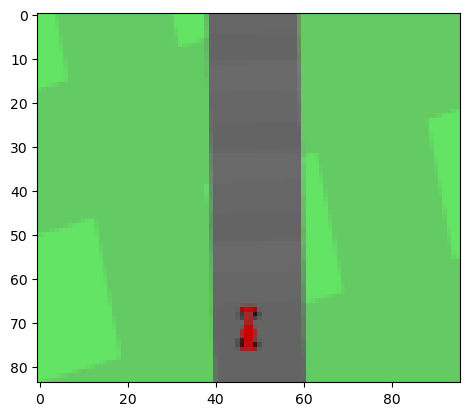

In [4]:
def cropImage(image):
    return image[:84, :]

def flippedImage(observations, actions):
    flipped_observations = []
    flipped_actions = []
    for i in range(len(observations)):
        image = observations[i].copy()
        image[:84, :] = np.fliplr(image[:84, :])
        flipped_observations.append(image)
        flipped_actions.append(actions[i] * np.array([-1, 1, 1]))
    return flipped_observations, flipped_actions

n = 150
plt.figure()
plt.imshow(observations[n]); 

plt.figure()
plt.imshow(cropImage(observations[n])); 


class_number
6    4283
0     418
3     418
7     233
1     106
4     106
Name: count, dtype: int64

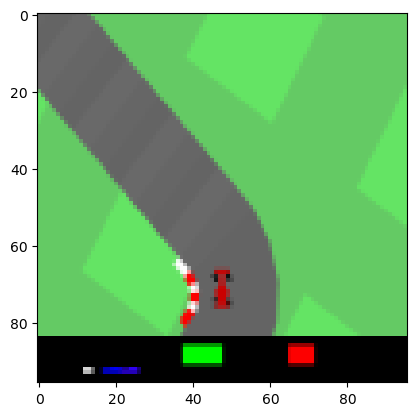

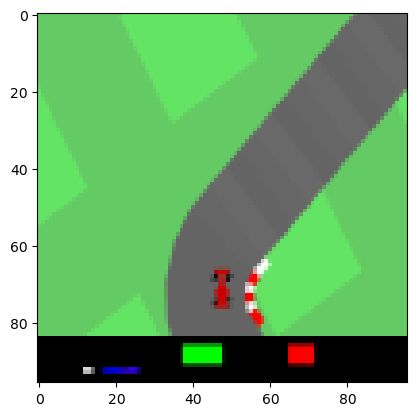

In [5]:
turn_observations = [observations[i] for i in range(len(class_number)) if class_number[i]<6]
turn_actions = [actions[i] for i in range(len(class_number)) if class_number[i]<6]
flipped_observations, flipped_actions = flippedImage(turn_observations, turn_actions)

n = 11
plt.figure()
plt.imshow(turn_observations[n]);  

plt.figure()
plt.imshow(flipped_observations[n]); 

observations.extend(flipped_observations)
actions.extend(flipped_actions)

df = pd.DataFrame(np.asarray(actions), columns=['steer', 'accel', 'brake'])
class_number, one_hot = actions_to_class(actions)
df['class_number'] = class_number
df['class_number'].value_counts()

In [6]:
save_demonstrations('data/augmented_training_data.npz', actions, observations)